In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.6 MB/s eta 0:00:00


## 데이터셋 로드 및 처리

1. Seed 고정:
- random.seed(42) 설정해 재현성 보장

2. 데이터셋 로드:
- HuggingFace load_dataset로 데이터셋 로드

3. 데이터셋 분할:
- 70% Train, 10% Validation, 20% Test로 분할

4. DataLoader 생성


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
import numpy as np

# Seed 설정
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 데이터셋 로드
ds = load_dataset("StockLlama/ETH-USD-2022-01-01_2024-08-30")
data = ds['train']

# Dataset 클래스 정의
class ReshapedDataset(Dataset):
    def __init__(self, data):
        self.inputs = [
            torch.tensor(input_id, dtype=torch.float32).unsqueeze(-1)
            for input_id in data['input_ids']
        ]
        self.labels = torch.tensor(data['label'], dtype=torch.float32)

         # 정규화 적용
        self.inputs = [(x - x.mean()) / x.std() for x in self.inputs]
        self.labels = (self.labels - self.labels.mean()) / self.labels.std()


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        input_data = self.inputs[idx]
        label = self.labels[idx]
        return input_data, label

# Dataset 인스턴스 생성
dataset = ReshapedDataset(data)

# 데이터셋 비율 설정
train_ratio = 0.7
valid_ratio = 0.1
test_ratio = 0.2

# 데이터셋 크기 계산
total_size = len(dataset)
train_size = int(total_size * train_ratio)
valid_size = int(total_size * valid_ratio)
test_size = total_size - train_size - valid_size

# 데이터셋 분리
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# DataLoader 생성 함수
def create_data_loader(dataset, batch_size=32):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 32
train_loader = create_data_loader(train_dataset, batch_size)
valid_loader = create_data_loader(valid_dataset, batch_size)
test_loader = create_data_loader(test_dataset, batch_size)

# DataLoader 확인
if __name__ == "__main__":
    for inputs, labels in train_loader:
        print("Inputs:", inputs.shape)
        print("Labels:", labels.shape)
        break


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/313 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/39.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/716 [00:00<?, ? examples/s]

Inputs: torch.Size([32, 256, 1])
Labels: torch.Size([32])


## 모델 정의

In [ ]:
import torch
from torch import nn

# RNN 모델 정의
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        return self.fc(out)

# LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

# GRU 모델 정의
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)

## 모델 생성 및 파라미터 정의

In [ ]:
# 하이퍼파라미터
input_dim = 1
hidden_dim = 64
output_dim = 1
num_layers = 3
batch_size = 32


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 생성
rnn_model = RNN(input_dim, hidden_dim, output_dim, num_layers)
gru_model = GRU(input_dim, hidden_dim, output_dim, num_layers)
lstm_model = LSTM(input_dim, hidden_dim, output_dim, num_layers)

## 손실 함수와 옵티마이저 설정
- 손실함수로 MSELoss 사용
- Optimizer로 AdamW를 사용
- Scheduler를 사용해 5step마다 학습률을 조정

In [65]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

#하이퍼파라미터
learning_rate = 0.0005
weight_decay = 1e-4
step_size = 15
gamma = 0.5

# 손실 함수
criterion = nn.MSELoss()

# RNN, GRU, LSTM에 대해 옵티마이저와 스케줄러 설정
rnn_optimizer = optim.AdamW(rnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
gru_optimizer = optim.AdamW(gru_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lstm_optimizer = optim.AdamW(lstm_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

rnn_scheduler = StepLR(rnn_optimizer, step_size=step_size, gamma=gamma)
gru_scheduler = StepLR(gru_optimizer, step_size=step_size, gamma=gamma)
lstm_scheduler = StepLR(lstm_optimizer, step_size=step_size, gamma=gamma)

## 정확도 계산 함수
- 회귀 모델 성능 평가를 위해 허용 오차 내의 예측값 비율을 기준으로 정확도 계산

In [ ]:
def calculate_accuracy(preds, labels, tolerance=0.1):
    # 절대 오차 계산
    absolute_errors = torch.abs(preds - labels.to(preds.device))

    # 허용 오차 내에서 정확한 예측 계산
    correct_within_tolerance = (absolute_errors <= tolerance).sum().item()
    total = labels.size(0)

    # 정확도 계산 (정확한 예측 비율 * 100)
    accuracy = (correct_within_tolerance / total) * 100
    return accuracy


## 모델 학습 및 평가 함수

In [55]:
def train_model(model, optimizer, scheduler, train_loader, criterion, device, tolerance):
    model.train()
    epoch_loss = 0.0
    correct_within_tolerance = 0  # 정확도 계산을 위한 누적 변수
    total_samples = 0  # 전체 샘플 수

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.unsqueeze(-1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)  # 출력과 타겟 차원 동일
        loss.backward()
        optimizer.step()

        # 손실 누적
        epoch_loss += loss.item() * inputs.size(0)  # 배치 손실을 전체 샘플 기준으로 누적

        # 정확도 계산
        absolute_errors = torch.abs(outputs - targets)
        correct_within_tolerance += (absolute_errors <= tolerance).sum().item()
        total_samples += targets.size(0)

    # 스케줄러 업데이트
    scheduler.step()

    # 평균 Loss 및 정확도 계산
    epoch_loss /= total_samples
    epoch_accuracy = (correct_within_tolerance / total_samples) * 100  # 퍼센트로 변환

    return epoch_loss, epoch_accuracy


def evaluate_model(model, val_loader, criterion, device, tolerance):
    model.eval()
    epoch_loss = 0.0
    correct_within_tolerance = 0  # 정확도 계산을 위한 누적 변수
    total_samples = 0  # 전체 샘플 수

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.unsqueeze(-1)  # (32,) -> (32, 1)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # 손실 누적
            epoch_loss += loss.item() * inputs.size(0)  # 배치 손실을 전체 샘플 기준으로 누적

            # 정확도 계산
            absolute_errors = torch.abs(outputs - targets)
            correct_within_tolerance += (absolute_errors <= tolerance).sum().item()
            total_samples += targets.size(0)

    # 평균 Loss 및 정확도 계산
    epoch_loss /= total_samples
    epoch_accuracy = (correct_within_tolerance / total_samples) * 100  # 퍼센트로 변환

    return epoch_loss, epoch_accuracy


## 결과 출력

허용 오차 tolerance = 0.1 설정


- RNN Test Accuracy: 29.86%
- LSTM Test Accuracy: 38.19%
- GRU  Test Accuracy: 90.28%

In [66]:
# 결과 저장을 위한 딕셔너리
results = {
    "model": [],
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "test_loss": [],
    "test_accuracy": [],
}

num_epochs = 50  # 에포크 수
tolerance = 0.1  # 정확도 계산 시 허용 오차

for model, optimizer, scheduler in zip(
    [rnn_model, gru_model, lstm_model],
    [rnn_optimizer, gru_optimizer, lstm_optimizer],
    [rnn_scheduler, gru_scheduler, lstm_scheduler]
):
    model_name = model.__class__.__name__
    print(f"Training {model_name}...")
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # 학습
        train_loss, train_accuracy = train_model(model, optimizer, scheduler, train_loader, criterion, device, tolerance)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # 평가
        val_loss, val_accuracy = evaluate_model(model, valid_loader, criterion, device, tolerance)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}, {model_name}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        print("-" * 50)

    # 테스트 평가
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device, tolerance)
    print(f"Test Results for {model_name}:")
    print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print("-" * 50)

    # 결과 저장
    results["model"].append(model_name)
    results["train_loss"].append(train_losses)
    results["train_accuracy"].append(train_accuracies)
    results["val_loss"].append(val_losses)
    results["val_accuracy"].append(val_accuracies)
    results["test_loss"].append(test_loss)
    results["test_accuracy"].append(test_accuracy)



Training RNN...
Epoch 1, RNN:
  Train Loss: 0.5471, Train Accuracy: 38.52%
  Val Loss: 0.5108, Val Accuracy: 22.54%
--------------------------------------------------
Epoch 2, RNN:
  Train Loss: 0.5347, Train Accuracy: 19.16%
  Val Loss: 0.5395, Val Accuracy: 18.31%
--------------------------------------------------
Epoch 3, RNN:
  Train Loss: 0.4666, Train Accuracy: 32.93%
  Val Loss: 0.4698, Val Accuracy: 23.94%
--------------------------------------------------
Epoch 4, RNN:
  Train Loss: 0.4718, Train Accuracy: 33.93%
  Val Loss: 0.5121, Val Accuracy: 25.35%
--------------------------------------------------
Epoch 5, RNN:
  Train Loss: 0.6192, Train Accuracy: 15.57%
  Val Loss: 0.6652, Val Accuracy: 9.86%
--------------------------------------------------
Epoch 6, RNN:
  Train Loss: 0.6366, Train Accuracy: 21.36%
  Val Loss: 0.6669, Val Accuracy: 9.86%
--------------------------------------------------
Epoch 7, RNN:
  Train Loss: 0.6327, Train Accuracy: 18.36%
  Val Loss: 0.6644, V

## 실험의 Training log 시각화

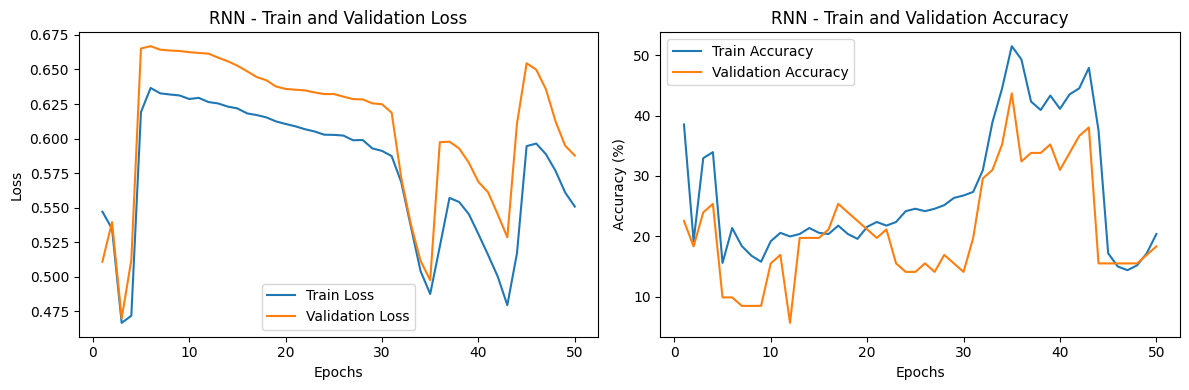

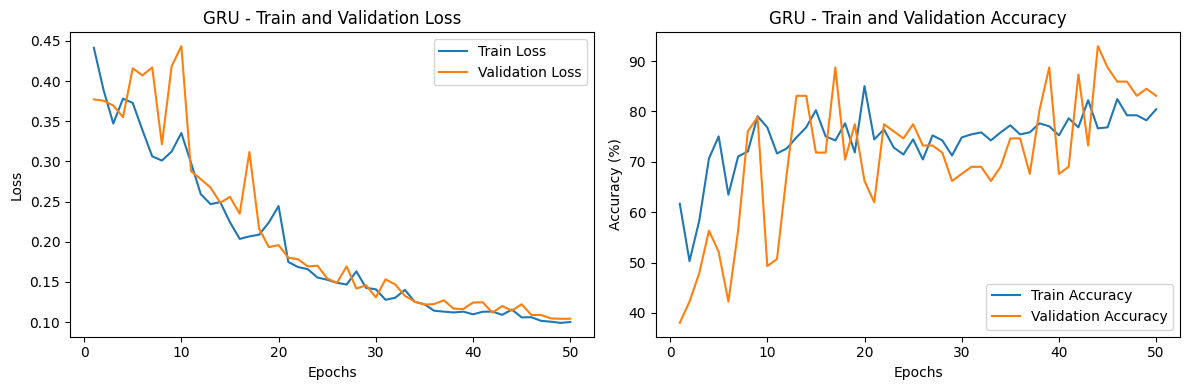

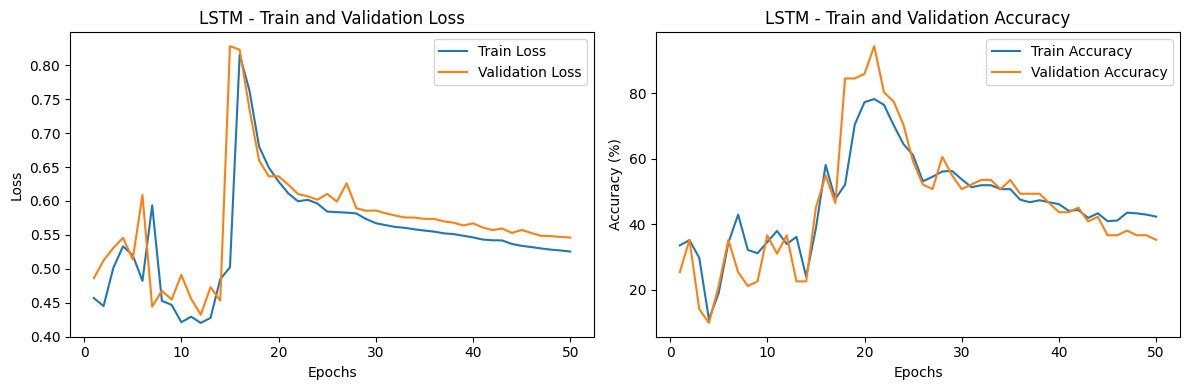

In [67]:
import matplotlib.pyplot as plt

# 시각화
def plot_results(results, num_epochs):
    for i, model_name in enumerate(results["model"]):
        epochs = range(1, num_epochs + 1)

        # 손실 그래프
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, results["train_loss"][i], label="Train Loss")
        plt.plot(epochs, results["val_loss"][i], label="Validation Loss")
        plt.title(f"{model_name} - Train and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        # 정확도 그래프
        plt.subplot(1, 2, 2)
        plt.plot(epochs, results["train_accuracy"][i], label="Train Accuracy")
        plt.plot(epochs, results["val_accuracy"][i], label="Validation Accuracy")
        plt.title(f"{model_name} - Train and Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy (%)")
        plt.legend()

        plt.tight_layout()
        plt.show()

# 시각화 함수 호출
plot_results(results, num_epochs)

## 분석 및 고찰

결과에 대한 분석

1. RNN:
  - 손실 부분에서는 초기에는 감소하다가 중간에 변동이 큰 영향을 보임. RNN이 순차 데이터에서 장기 의존성을 학습하는데 문제가 있는 것으로 나타남. 정확도 부분에서도 불안전한 곡선을 보임

2. LSTM:

   - 손실 부분에서는 학습 초기에 급격히 증가한 후 감소, 정확도 부분에서는 학습과 검증 초기에는 급격하게 증가하지만 이후 변동폭이 커지면서 정확도가 낮아지는 모습을 보임
   - 데이터셋이 큰 데이터셋이 아니고, GRU에 비해 매개변수도 많아서 작은 데이터셋에 과적합 되었을 가능성이 있음

3. GRU:
    - 손실 부분에서는 학습을 진행할수록 손실이 감소하고 검증 손실 또한 점차 줄어드는 모습을 보임. 정확도 부분에서도 학습과 검증 정확도가 상승하며 안정적으로 높은 정확도를 보임

    
모델 성능 비교
- RNN
  - 장점 : 구조가 단순하고 계산 속도가 빠름
  - 단점 : 기울기 소멸 문제 발생, 학습 성능이 제한적

- LSTM
  - 장점 : 복잡한 시계열 데이터에 적합
  - 단점 : 구조가 복잡하여 학습 속도가 느림, 과적합 가능성이 있음

- GRU
  - 장점 : LSTM보다 단순한 구조로 학습 속도가 빠름, 적은 데이터에서도 좋은 성능
  -단점 : 긴 시퀀스 데이터에서는 성능이 안좋을 수 있음



